# Sarcasm Detection

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from data_processing import get_clean_data  # 导入预处理函数
from collections import Counter
from wordcloud import WordCloud
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, FastText
from models import build_cnn_model, build_lstm_model  # 从 models.py 中导入模型构建函数
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.manifold import TSNE
from PIL import Image

Original datasets looks like:

Data Preprocessing:1.data_cleaned
                   2.Data Balancing
                   3.分词与标准化与emoji：已完成（对于emoji有点困惑

In [2]:
train_cleaned, train_labels, test_cleaned, test_labels = get_clean_data(
    "../data/datasets/ghosh/train_sample.txt",
    "../data/datasets/ghosh/test_sample.txt",
    save=True
)

In [3]:
with open("train_tweets_clean.txt", "r", encoding="utf-8") as f:
    train_lines = f.read().splitlines()

with open("test_tweets_clean.txt", "r", encoding="utf-8") as f:
    test_lines = f.read().splitlines()

train_cleaned_df = pd.DataFrame(train_lines, columns=["Text"])
test_cleaned_df = pd.DataFrame(test_lines, columns=["Text"])

After preprocessing, datasets looks like:

Data balancing : Here it is balanced for sample data ,if not balances , use 如果饼图显示数据不均衡（如讽刺类样本远少于非讽刺类），需通过过采样（SMOTE）、欠采样或类别权重（Class Weight）优化模型性能。

In [11]:
def plot_pie_chart(labels, title):
    # 统计标签数量
    label_counts = [sum(labels == 0), sum(labels == 1)]
    label_names = ['Non-Sarcastic', 'Sarcastic']
    
    # 设置颜色和样式
    colors = ['#66b3ff', '#ff9999']  # 自定义颜色
    
    # 创建图像并设置背景为白色
    plt.figure(figsize=(8, 8), facecolor='white') 
    
    # 绘制饼图
    wedges, texts, autotexts = plt.pie(
        label_counts,
        labels=label_names,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 12, 'color': 'black'},  # 设置文字颜色和大小
    )
    
    # 设置标题和布局
    plt.title(title, fontsize=15, pad=20)
    plt.axis('equal')
    
    # 调整百分比标签的样式
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_color('white')  # 百分比文字设为白色（与深色背景对比）
    
    plt.tight_layout()  # 自动调整布局
    plt.show()

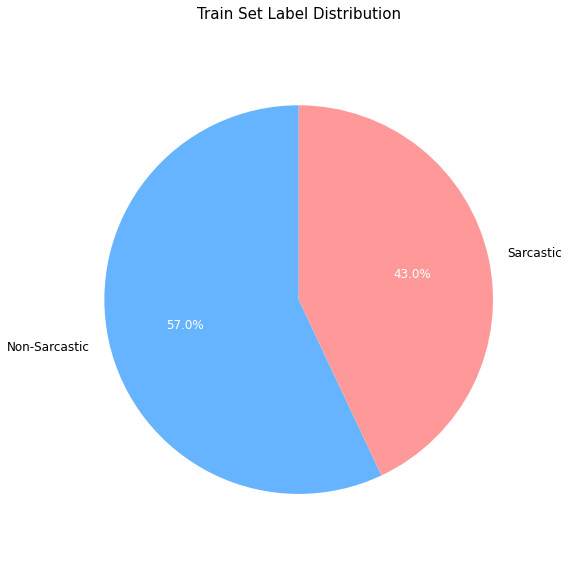

In [12]:
plot_pie_chart(train_labels, 'Train Set Label Distribution')

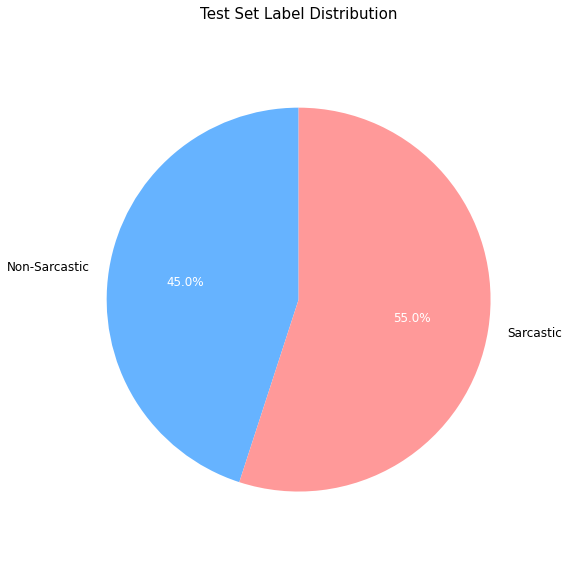

In [13]:
plot_pie_chart(test_labels, 'Test Set Label Distribution')

Show high-frequency words:

In [ ]:
all_words = []
for text in train_cleaned_df["Text"]:
    all_words.extend(text.split())

word_counts = Counter(all_words)

top_words = word_counts.most_common(20)
print("Top 20 words:", top_words)

Top 20 words: [('be', 69), ('.', 59), ('the', 43), ('I', 43), ('to', 38), ('@user', 37), ('you', 35), (',', 29), ('a', 28), ('!', 28), ('with', 23), ('of', 22), ('and', 18), ('have', 18), ('on', 17), ('it', 16), ('face', 16), ('"', 16), ('love', 15), ('that', 15)]


C:\Users\18052\AppData\Local\Temp\ipykernel_14000\3597428493.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


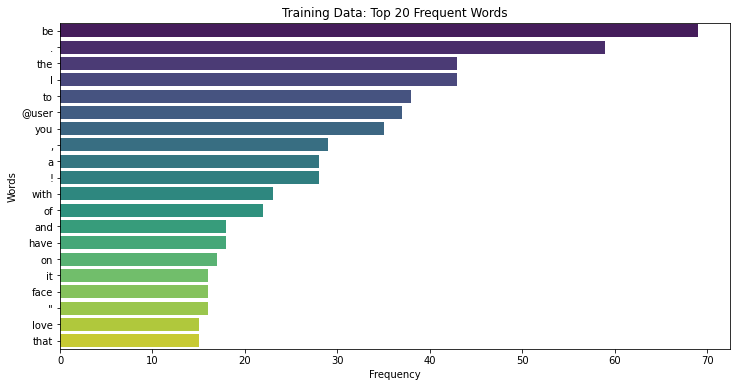

In [15]:
words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Training Data: Top 20 Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')

# 显示图像
plt.show()

In [16]:
word_freq = dict(top_words)

# 创建词云对象并配置参数
wordcloud = WordCloud(
    width=800,               # 图像宽度
    height=400,              # 图像高度
    background_color='white',# 背景颜色（解决透明问题）
    colormap='viridis',      # 颜色主题（可选：'plasma', 'magma', 'inferno'等）
    max_words=50,            # 最多显示词数（即使超过前20也会自动限制）
    max_font_size=150,       # 最大字体大小
    stopwords=None,          # 可在此添加要排除的停用词
    contour_width=1,         # 轮廓线宽度
    contour_color='steelblue'# 轮廓线颜色
).generate_from_frequencies(word_freq)


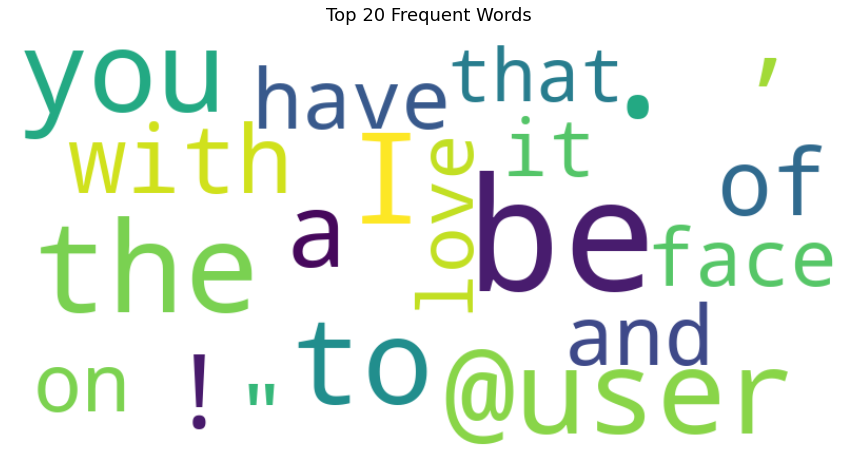

In [17]:
# 绘制词云
plt.figure(figsize=(12, 8), facecolor='white')  # 设置画布大小和背景
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # 关闭坐标轴
plt.title("Top 20 Frequent Words", fontsize=18, pad=20)
plt.tight_layout()
plt.show()

这里是生成增强词云，作用：辅助理解数据分布，指导后续特征工程（例如发现讽刺类依赖特定词汇，可手动添加关键词特征）

In [50]:
# 定义类别名称
labels = {0: "Non-Sarcastic", 1: "Sarcastic"}

# 读取 Windows 字体
font_path = "C:/Windows/Fonts/Arial.ttf"  # 可替换为合适的字体

# 遍历类别（0: 非讽刺, 1: 讽刺）
for label in [0, 1]:
    # 获取该类别的所有文本
    class_words = []
    for text, lbl in zip(train_cleaned, train_labels):  # 直接用 train_cleaned 和 train_labels
        if lbl == label:
            class_words.extend(text.split())

    # 计算词频
    class_word_counts = Counter(class_words)

In [55]:
# 生成词云
wordcloud = WordCloud(
    font_path=font_path,
    width=800,
    height=400,
    background_color='black' if label == 1 else 'white',  # 讽刺类用黑色背景
    colormap='coolwarm' if label == 1 else 'Blues',
    ).generate_from_frequencies(class_word_counts)

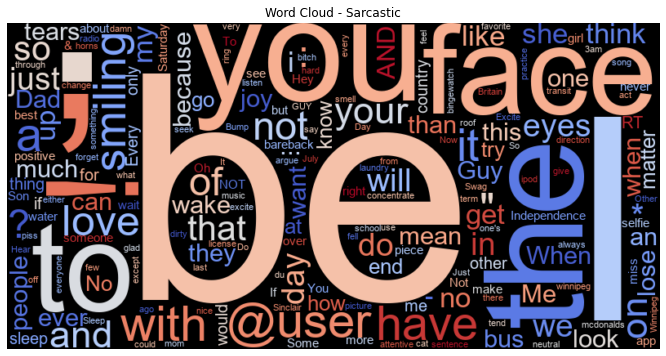

In [56]:
 # 绘制词云
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title(f"Word Cloud - {labels[label]}")
plt.show()

 Vectorization：

In [18]:
from gensim.models import Word2Vec, FastText

In [20]:
train_sentences = train_cleaned_df["Text"].apply(lambda x: x.split()).tolist()
test_sentences = test_cleaned_df["Text"].apply(lambda x: x.split()).tolist()

In [21]:
skipgram_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, sg=1, min_count=1, workers=4)
skipgram_model.save("skipgram.model")

In [22]:
fasttext_model = FastText(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)
fasttext_model.save("fasttext.model")

展示部分词向量

In [11]:
# 选取几个单词展示词向量
words = ["love", "my", "mom", "like", "just"]

print("Skip-gram")
for word in words:
    if word in skipgram_model.wv:
        print(f"{word}: {skipgram_model.wv[word][:5]}")  # 仅展示前5个维度

Skip-gram
love: [ 0.0033984   0.00861393  0.00138705  0.0082688  -0.00935446]
my: [ 0.0053937   0.00297525 -0.01076279  0.00685094 -0.00698826]
mom: [-0.00038277  0.00436646  0.0007396   0.003766   -0.00822128]
like: [-0.0041687  -0.00663539  0.00905645  0.00450114 -0.00133147]
just: [-0.00535828 -0.00484555 -0.00930921 -0.00540644  0.00328046]


In [12]:
print("FastText")
for word in words:
    if word in fasttext_model.wv:
        print(f"{word}: {fasttext_model.wv[word][:5]}")

FastText
love: [-0.00380938  0.00047163 -0.00141727  0.00353753  0.00149987]
my: [ 0.00290381  0.00189729  0.001617    0.00323172 -0.00172936]
mom: [-0.00123451 -0.00050335  0.00012947  0.00161764  0.00149152]
like: [ 1.4855972e-03 -4.1661761e-03  2.8692514e-03  4.2900465e-05
 -2.5856479e-03]
just: [ 0.00101466 -0.00263574  0.00162182 -0.00044807 -0.0011162 ]


模型训练优化（未做）

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_cleaned_df["Text"].tolist())
vocab_size = len(tokenizer.word_index) + 1  # 词汇表大小

In [24]:
X_train = tokenizer.texts_to_sequences(train_cleaned_df["Text"].tolist())
X_test = tokenizer.texts_to_sequences(test_cleaned_df["Text"].tolist())

In [25]:
train_lengths = [len(seq) for seq in X_train]
max_len = int(np.percentile(train_lengths, 95))
if max_len < 10:
    max_len = 10

In [26]:
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

In [27]:
# 构造嵌入矩阵函数：将 tokenizer 中的词汇与词向量模型对齐
def create_embedding_matrix(model, tokenizer, vocab_size, embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in model.wv:
            embedding_matrix[i] = model.wv[word]
    return embedding_matrix

In [28]:
embedding_dim = 100  # 词向量维度（与训练时保持一致）

In [29]:
skipgram_embedding_matrix = create_embedding_matrix(skipgram_model, tokenizer, vocab_size, embedding_dim)

In [30]:
fasttext_embedding_matrix = create_embedding_matrix(fasttext_model, tokenizer, vocab_size, embedding_dim)

In [43]:
def visualize_embeddings(embedding_matrix, tokenizer, title, n_words=200):
    # 提取高频词和对应向量
    words = list(tokenizer.word_index.keys())[:n_words]
    indices = [tokenizer.word_index[word] for word in words]
    word_vectors = embedding_matrix[indices]
    
    # 使用 t-SNE 降维
    tsne = TSNE(n_components=2, random_state=42)
    vectors_2d = tsne.fit_transform(word_vectors)
    
    # 可视化
    plt.figure(figsize=(10,8))
    plt.scatter(vectors_2d[:,0], vectors_2d[:,1], alpha=0.5)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(vectors_2d[i,0], vectors_2d[i,1]))
    plt.title(f'Word Embeddings Visualization ({title})')
    plt.show()

Exception in thread Thread-68:
Traceback (most recent call last):
  File "c:\Users\18052\anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\18052\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\18052\anaconda3\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\18052\anaconda3\lib\subprocess.py", line 1479, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\18052\anaconda3\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc8 in position 24: invalid continuation byte
c:\Users\18052\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has no attribute 'splitlines'
Returning the number 

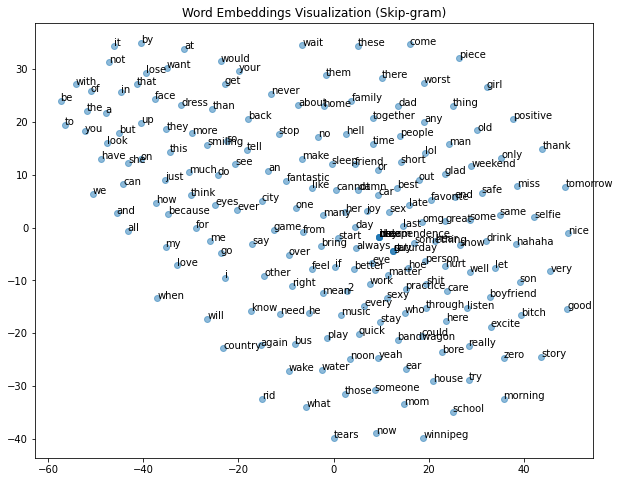

In [44]:
visualize_embeddings(skipgram_embedding_matrix, tokenizer, 'Skip-gram')

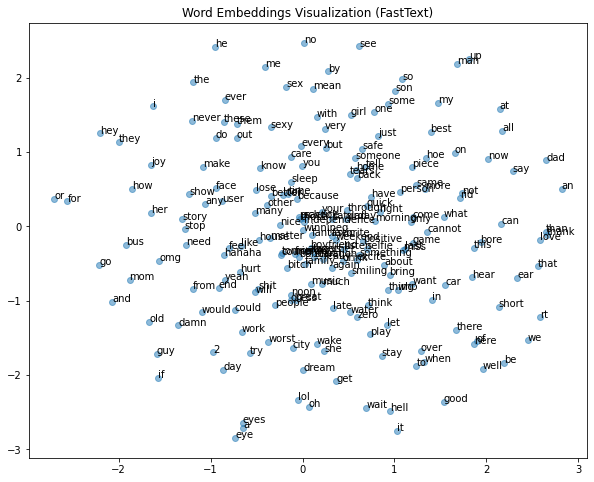

In [45]:
visualize_embeddings(fasttext_embedding_matrix, tokenizer, 'FastText')

可做：交互式词向量投影

位置：词向量训练完成后（生成skipgram_embedding_matrix和fasttext_embedding_matrix后）。

作用：验证词向量质量，辅助模型调优（例如发现语义不相关的词聚集时，需调整词向量训练参数）。

目标：将高维词向量（如100维的Skip-gram或FastText向量）降维到2D/3D空间，通过可视化探索词与词之间的语义关系。

工具：常用工具包括：

TensorBoard Projector（集成在TensorFlow中，支持动态交互）

Plotly（生成可旋转/缩放的3D图）

PyVis（基于Web的交互式网络图）

In [31]:
cnn_skipgram = build_cnn_model(skipgram_embedding_matrix, vocab_size, max_len, embedding_dim)

c:\Users\18052\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:
cnn_fasttext = build_cnn_model(fasttext_embedding_matrix, vocab_size, max_len, embedding_dim)

In [33]:
lstm_skipgram = build_lstm_model(skipgram_embedding_matrix, vocab_size, max_len, embedding_dim)

In [34]:
lstm_fasttext = build_lstm_model(fasttext_embedding_matrix, vocab_size, max_len, embedding_dim)

In [37]:
epochs = 5
batch_size = 32

history_lstm = lstm_fasttext.fit(X_train, train_labels, epochs=epochs, batch_size=batch_size,
                               validation_data=(X_test, test_labels))

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step - accuracy: 0.6582 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6944
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5377 - loss: 0.6915 - val_accuracy: 0.4500 - val_loss: 0.6977
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5061 - loss: 0.6912 - val_accuracy: 0.4500 - val_loss: 0.7042
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5707 - loss: 0.6862 - val_accuracy: 0.4500 - val_loss: 0.7191
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5707 - loss: 0.6886 - val_accuracy: 0.4500 - val_loss: 0.7193


In [38]:
lstm_fasttext_pred_probs = cnn_fasttext.predict(X_test)
lstm_preds = (lstm_fasttext_pred_probs > 0.5).astype(int).reshape(-1)
print("=== LSTM(fasttext) Classification Report ===")
print(classification_report(test_labels, lstm_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
=== LSTM(fasttext) Classification Report ===
              precision    recall  f1-score   support

           0       0.45      1.00      0.62         9
           1       0.00      0.00      0.00        11

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



c:\Users\18052\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\18052\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\18052\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
epochs = 5
batch_size = 32

history_cnn = cnn_fasttext.fit(X_train, train_labels, epochs=epochs, batch_size=batch_size,
                               validation_data=(X_test, test_labels))

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.5203 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5603 - loss: 0.6911 - val_accuracy: 0.4500 - val_loss: 0.6942
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5455 - loss: 0.6914 - val_accuracy: 0.4500 - val_loss: 0.6944
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5842 - loss: 0.6885 - val_accuracy: 0.4500 - val_loss: 0.6955
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5853 - loss: 0.6853 - val_accuracy: 0.4500 - val_loss: 0.6977


In [36]:
cnn_pred_probs = cnn_fasttext.predict(X_test)
cnn_preds = (cnn_pred_probs > 0.5).astype(int).reshape(-1)
print("=== CNN (fasttext) Classification Report ===")
print(classification_report(test_labels, cnn_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
=== CNN (fasttext) Classification Report ===
              precision    recall  f1-score   support

           0       0.45      1.00      0.62         9
           1       0.00      0.00      0.00        11

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



c:\Users\18052\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\18052\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\18052\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
epochs = 5
batch_size = 32

# 训练 CNN 模型（使用 skip-gram 词向量）
history_cnn = cnn_skipgram.fit(X_train, train_labels, epochs=epochs, batch_size=batch_size,
                               validation_data=(X_test, test_labels))

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.4112 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6953
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6252 - loss: 0.6884 - val_accuracy: 0.4500 - val_loss: 0.6960
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5738 - loss: 0.6851 - val_accuracy: 0.4500 - val_loss: 0.6983
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5665 - loss: 0.6789 - val_accuracy: 0.4500 - val_loss: 0.7048
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5500 - loss: 0.6736 - val_accuracy: 0.4500 - val_loss: 0.7139


In [28]:
# 预测与评估
cnn_pred_probs = cnn_skipgram.predict(X_test)
cnn_preds = (cnn_pred_probs > 0.5).astype(int).reshape(-1)
print("=== CNN (skip-gram) Classification Report ===")
print(classification_report(test_labels, cnn_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
=== CNN (skip-gram) Classification Report ===
              precision    recall  f1-score   support

           0       0.45      1.00      0.62         9
           1       0.00      0.00      0.00        11

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



c:\Users\18052\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\18052\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\18052\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

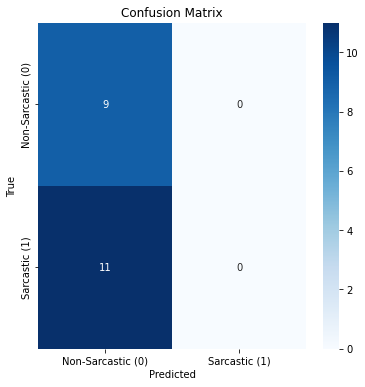

In [41]:
class_names = ['Non-Sarcastic (0)', 'Sarcastic (1)']
plot_confusion_matrix(test_labels, cnn_preds, class_names)

In [58]:
def plot_roc_curve(y_true, y_pred_probs, model_name):
    # 计算 ROC 曲线和 AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    auc = roc_auc_score(y_true, y_pred_probs)
    
    # 绘制曲线
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 随机猜测线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

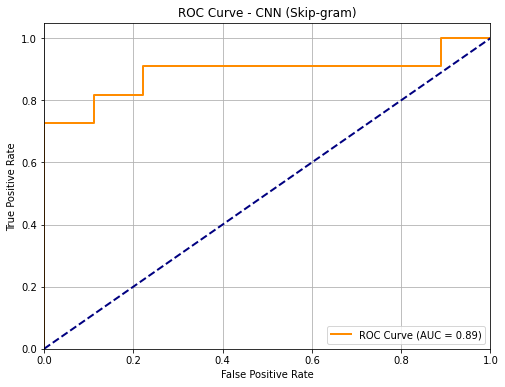

In [59]:
plot_roc_curve(test_labels, cnn_pred_probs, "CNN (Skip-gram)")